In [44]:
from data_utils import load_features
from transforms import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D, Activation
from keras.layers import AtrousConvolution2D, AveragePooling2D, LeakyReLU, PReLU
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.models import load_model
from keras.regularizers import l2
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("white")

## Load resampled time domain features

In [237]:
patient = 2
features = [Interp(), Resample(600)]

%time X, y, files = load_features('train_{}'.format(patient), features)

Wall time: 12.4 s


In [183]:
print X.shape
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

(2389L, 16L, 600L)


## 70/30 cv split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Scale to zero mean and unit variance

In [185]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Data Augmentation to balance classes with smote

In [186]:
sm = SMOTE(kind='regular')
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

## Reshape to (N, channels, samples, 1) for 2d convnet

In [187]:
X_train_2d_sm = X_train_sm.reshape((len(X_train_sm), 16, 600, 1))
X_test_2d = X_test.reshape((len(X_test), 16, 600, 1))

## Build simple 2d convnet

In [223]:
cnn = Sequential()
cnn.add(AtrousConvolution2D(64, 3, 1, atrous_rate=(2,2), border_mode='valid', input_shape=(16, 600, 1)))
cnn.add(Activation('relu'))
cnn.add(PReLU())
cnn.add(AveragePooling2D(pool_size=(2, 1)))
cnn.add(AtrousConvolution2D(64, 3, 1, atrous_rate=(2,2), border_mode='valid'))
cnn.add(Activation('relu'))
cnn.add(PReLU())
cnn.add(AveragePooling2D(pool_size=(2, 1)))
cnn.add(Flatten())
cnn.add(Dense(512, init='he_normal'))
cnn.add(PReLU())
cnn.add(Dropout(0.5))
cnn.add(Dense(512, init='he_normal'))
cnn.add(PReLU())
cnn.add(Dropout(0.5))
cnn.add(Dense(1, init='he_normal', activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(patience=4)

In [227]:
cnn.fit(X_train_2d_sm, y_train_sm, nb_epoch=1, batch_size=256, validation_data=(X_test_2d, y_test), callbacks=[earlystop])

Train on 3132 samples, validate on 717 samples
Epoch 1/1
3132/3132 [==============================] - 1s - loss: 0.4557 - acc: 0.7723 - val_loss: 0.4570 - val_acc: 0.7992


In [228]:
preds = cnn.predict_classes(X_test_2d)
preds_train = cnn.predict_classes(X_train_2d_sm)

3104/3132 [============================>.] - ETA: 0s

## Confusion matrix and ROC score train

AUC: 0.824393


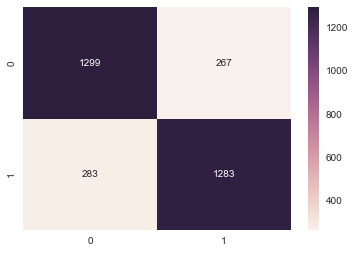

In [229]:
sns.heatmap(confusion_matrix(y_train_sm, preds_train), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_train_sm, preds_train))

## Confusion matrix and ROC score trest

AUC: 0.591905


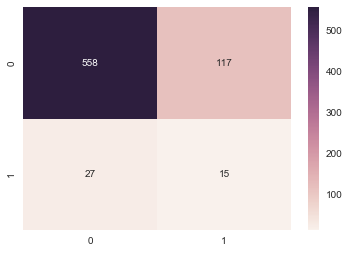

In [230]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_test, preds))

## Load current best model
cnn only trained for 3 epochs

In [231]:
cnn.save('cnn_artorious_interp_600_adam_3.h5')

In [236]:
cnn2 = load_model(os.path.join('trained_models', 'auc65_cnn_artorious_interp_600_adam_2.h5'))

In [137]:
preds2 = cnn2.predict_classes(X_test_2d)
preds2_train = cnn2.predict_classes(X_train_2d_sm)

2976/3040 [============================>.] - ETA: 0s

AUC: 0.592434


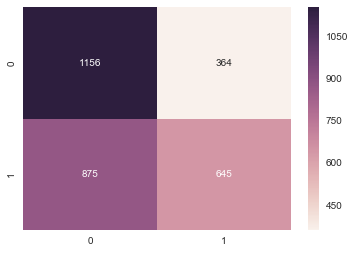

In [139]:
sns.heatmap(confusion_matrix(y_train_sm, preds2_train), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_train_sm, preds2_train))

AUC: 0.470581


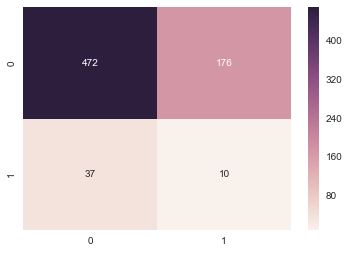

In [140]:
sns.heatmap(confusion_matrix(y_test, preds2), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_test, preds2))

In [238]:
%time X, files = load_features('test_{}'.format(patient), features)
X_2d = X.reshape((len(X), 16, 600, 1))

Wall time: 11.8 s


In [239]:
preds = np.squeeze(cnn2.predict_classes(X_2d))

2208/2227 [============================>.] - ETA: 0s

In [240]:
from data_utils import preds_to_df, preds_to_csv
preds_1 = preds_to_df(preds, files)
preds_to_csv(preds, files, 'auc65_cnn_artorious_interp_re600_adam_2.csv')

In [241]:
np.squeeze(preds).sum()

4

In [242]:
from data_utils import get_skipped

In [247]:
get_skipped('test_1').to_csv('skipped_1.csv', index=False)
get_skipped('test_2').to_csv('skipped_2.csv', index=False)
get_skipped('test_3').to_csv('skipped_3.csv', index=False)

In [248]:
from glob import glob

In [303]:
pred_files = glob(os.path.join('predictions', '*'))

In [257]:
pred_files = [f for f in pred_files if 'fft' not in f]

In [261]:
import pandas as pd

In [292]:
dfs = [pd.read_csv(f) for f in pred_files]

In [270]:
sub = pd.concat(dfs)

In [273]:
sub.to_csv('conv_sub.csv', index=False)

In [304]:
pred_files = [f for f in pred_files if ('xgboost' in f) or ('skipped' in f)]

In [306]:
dfs = [pd.read_csv(f) for f in pred_files]

In [305]:
pred_files

['predictions\\corr_xgboost_1.csv',
 'predictions\\corr_xgboost_2.csv',
 'predictions\\corr_xgboost_3.csv',
 'predictions\\skipped_1.csv',
 'predictions\\skipped_2.csv',
 'predictions\\skipped_3.csv']

In [308]:
sub2 = pd.concat(dfs)

In [310]:
sub2.to_csv('xgb_corr_sub.csv', index=False)